# Genre Classification using Support-vector Machine

In [1]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm #containts the class that implements the machine to analyze music
import IPython.display as ipd
import scipy as sp

# Feature computation

In [2]:
#we skip the preliminary elaboration of the signal 
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal. We take the magnitude od the signal, windowing it
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024, #number of points in which fft will be done in window.
        hop_length=512,)
        )
    
    # Find the weights of the mel filters (in librosa) we must specify: the original f of the signal, what are the points used for 
    #STFF (Short Transfer Fourier Function), how many rectangular filters we want and Min and Max Frequency of the filter. 
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33, #in hz, we decide it. those values are pretty standard
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16) #we added 1e-16 just to avoid log(0) but is an inignificant value.
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc #n_mfcc x no. of windows

### Compute training features

In [3]:
classes = ['rock', 'pop', 'reggae','disco'] #now I wanna train my algorithm.
n_mfcc = 35
n_chroma = 12
n_spec_roll = 1
n_spec_centr = 1
n_feat_weights = n_mfcc + n_chroma + n_spec_roll + n_spec_centr
dict_train_features = {'rock': [], 'pop': [], 'reggae': [], 'disco': []}

for c in classes:
    print("Sto analizzando " + '{}'.format(c))
    train_root = 'C:/Users/Claudio/Desktop/PreProcessed/{}/training/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.mp3')]
    n_train_samples = len(class_train_files)
    
    train_features = np.zeros((n_train_samples, n_feat_weights))
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        mfcc_mean = np.mean(mfcc, axis = 1)
        chroma = librosa.feature.chroma_stft(audio, fs)
        chroma_mean = np.mean(chroma, axis = 1)
        spec_roll = librosa.feature.spectral_rolloff(audio, fs)
        spec_roll_mean = np.mean(spec_roll, axis = 1)
        spec_centr = librosa.feature.spectral_centroid(audio, fs)
        spec_centr_mean = np.mean(spec_centr, axis = 1)
        train_features[index, :] = np.concatenate((mfcc_mean, chroma_mean, spec_roll_mean, spec_centr_mean), axis = 0)
    dict_train_features[c] = train_features
    print(dict_train_features[c].shape)
    
print(mfcc.shape)

Sto analizzando rock


C:\Users\Claudio\miniconda3\envs\CMRM\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(30, 49)
Sto analizzando pop
(30, 49)
Sto analizzando reggae
(30, 49)
Sto analizzando disco
(30, 49)
(35, 1293)


In [4]:
mfcc.shape[1]

1293

In [5]:
dict_train_features['rock'].shape

(30, 49)

### Compute test features

In [6]:
#the syntax for test files is pretty the same. 
dict_test_features = {'rock': [], 'pop': [], 'reggae': [], 'disco': []}

for c in classes:
    test_root = 'C:/Users/Claudio/Desktop/PreProcessed/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.mp3')]
    n_test_samples = len(class_test_files)
    
    test_features = np.zeros((n_train_samples, n_feat_weights))
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        mfcc_mean = np.mean(mfcc, axis = 1)
        chroma = librosa.feature.chroma_stft(audio, fs)
        chroma_mean = np.mean(chroma, axis = 1)
        spec_roll = librosa.feature.spectral_rolloff(audio, fs)
        spec_roll_mean = np.mean(spec_roll, axis = 1)
        spec_centr = librosa.feature.spectral_centroid(audio, fs)
        spec_centr_mean = np.mean(spec_centr, axis = 1)
        test_features[index, :] = np.concatenate((mfcc_mean, chroma_mean, spec_roll_mean, spec_centr_mean), axis = 0)
    dict_test_features[c] = test_features
    print(dict_test_features[c].shape)

(70, 49)
(70, 49)
(70, 49)
(70, 49)


### Feature visualization

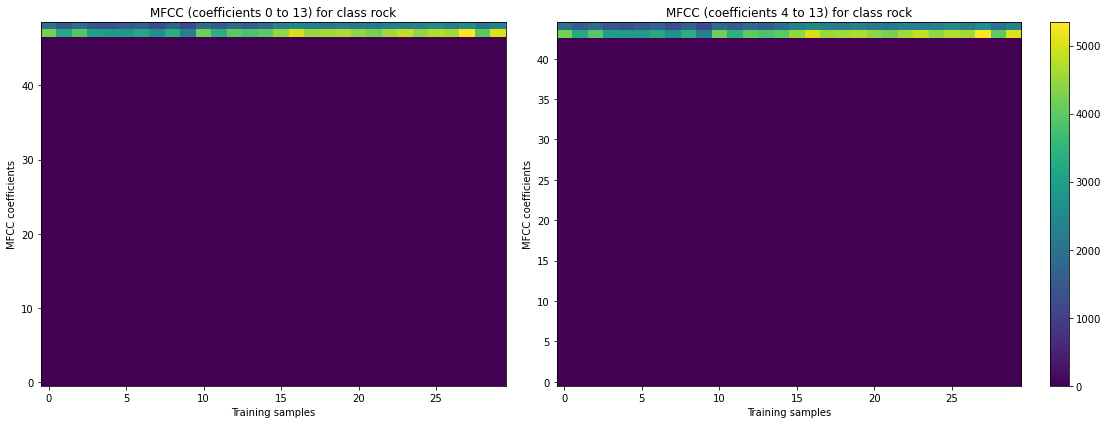

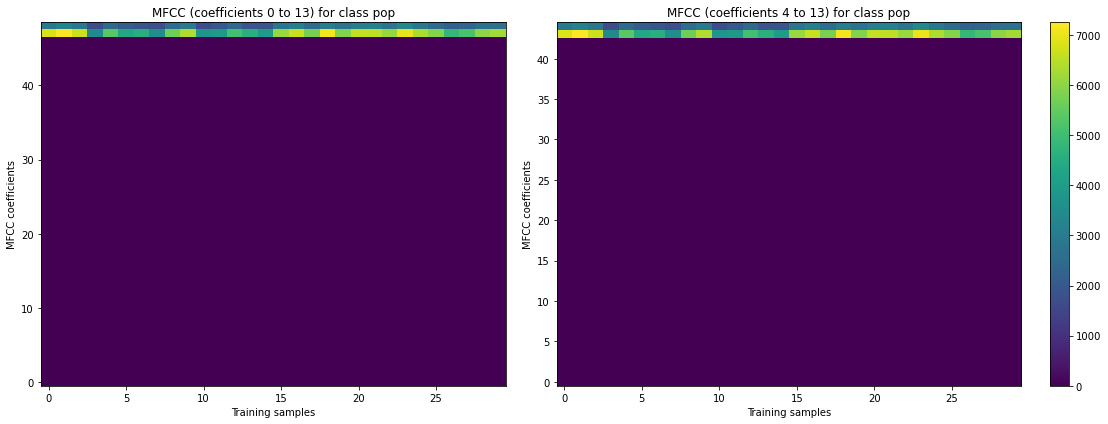

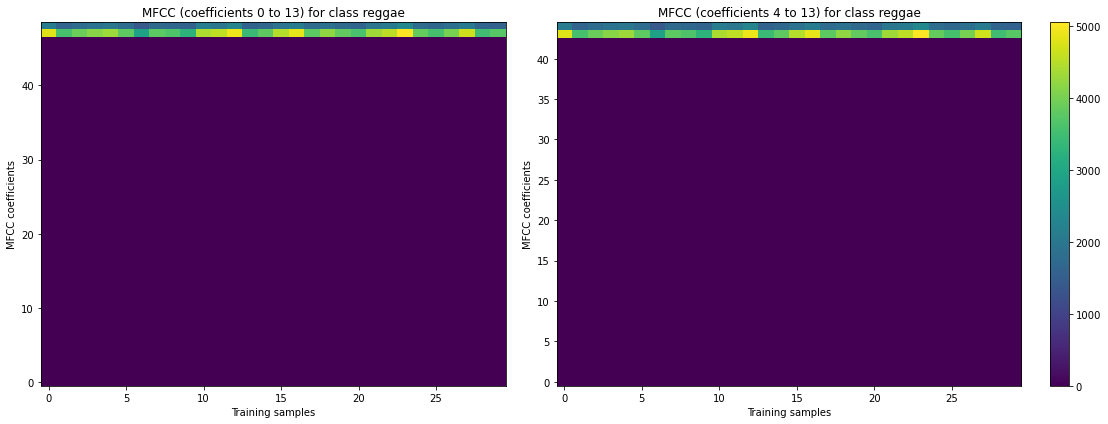

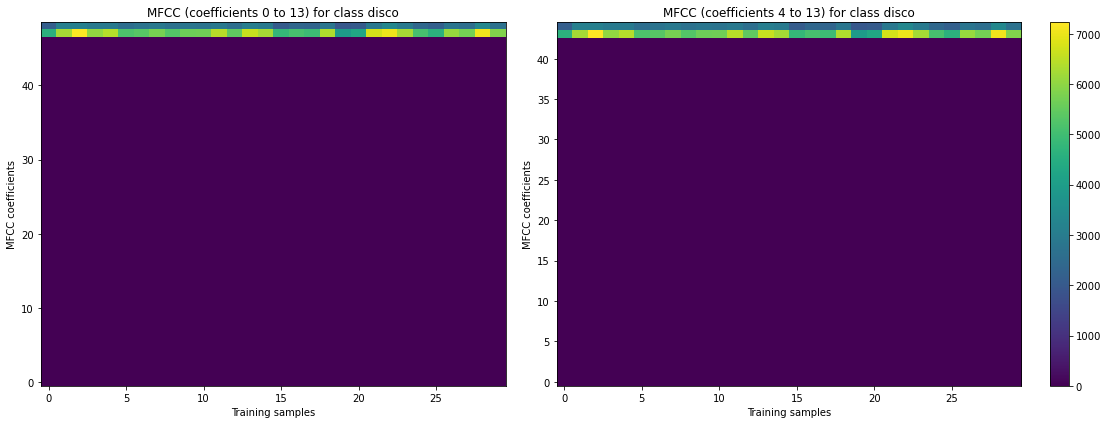

In [7]:
for c in classes:
    mfcc = dict_train_features[c].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

# SVM: multiclass case

In [8]:
class_0 = 'rock'
class_1 = 'pop'
class_2 = 'reggae'
class_3 = 'disco'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]
X_train_3 = dict_train_features[class_3]

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2
y_train_3 = np.ones((X_train_3.shape[0],))*3

#y_train = np.concatenate((y_train_class_0, y_train_class_1, y_train_class_1), axis=0) 


In [9]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]
X_test_3 = dict_test_features[class_3]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2
y_test_3 = np.ones((X_test_1.shape[0],))*3

y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)


### Normalize features

In [10]:
feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2, X_train_3), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2, X_train_3), axis=0), axis=0)

X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)
X_train_3_normalized = (X_train_3 - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min) #we concatenate to obtain max/min
X_test_3_normalized = (X_test_3 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized, X_test_3_normalized), axis=0)


### Define and train a model for each couple of classes

In [11]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_03 = sklearn.svm.SVC(**SVM_parameters, probability=True)

clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_13 = sklearn.svm.SVC(**SVM_parameters, probability=True)

clf_23 = sklearn.svm.SVC(**SVM_parameters, probability=True)


In [12]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_03.fit(np.concatenate((X_train_0_normalized, X_train_3_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_3), axis=0))


clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0)) 

clf_13.fit(np.concatenate((X_train_1_normalized, X_train_3_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_3), axis=0)) 


clf_23.fit(np.concatenate((X_train_2_normalized, X_train_3_normalized), axis=0), 
           np.concatenate((y_train_2, y_train_3), axis=0)) 
#now we have a tree of model.

SVC(C=1, probability=True)

### Evaluate each classifier

In [13]:
#now we predict test on label. They're all binary classifiers. We have 3 prediction and we must extract the most present.
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_03 = clf_03.predict(X_test_mc_normalized).reshape(-1, 1)

y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_13 = clf_13.predict(X_test_mc_normalized).reshape(-1, 1)

y_test_predicted_23 = clf_23.predict(X_test_mc_normalized).reshape(-1, 1)


### Majority voting

In [14]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_03, y_test_predicted_12, y_test_predicted_13, y_test_predicted_23 ), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [16]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

##Compute confusion matrix for multiclass

In [17]:
#we fill the matrix for each sample
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)): #the element in position"label" and the element in predicted class 
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [18]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[29. 11. 10. 20.]
 [ 7. 41.  1. 21.]
 [37.  7. 10. 16.]
 [16. 13.  7. 34.]]
